# 5.AP&DV axis analysis

## Packages

In [1]:
import os
import sys

import numpy as np
import gseapy as gp
from sklearn.decomposition import PCA
from bioinfokit.visuz import GeneExpression

sys.path.insert(0, "/home/yao/PythonProject/Yao_packages/spateo-release")
sys.path.insert(0, "/home/yao/PythonProject/Test_packages/dynamo-release")

import dynamo as dyn
import spateo as st

/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/yao/.local/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and poin

## Data source

In [2]:
os.chdir("/media/yao/Yao/Projects/Project_spateo/Data/three_dims_analysis_v3")
embryo_adata = st.read_h5ad(f"tdr_h5ad/stage_E7-9h/E7-9h_cellbin_tdr_v2.h5ad")
embryo_adata.X = embryo_adata.layers["counts_X"]
embryo_adata.layers["log1p_X"] = np.log1p(embryo_adata.layers["counts_X"])
embryo_adata.uns["pp"] = {}
dyn.pp.normalize_cell_expr_by_size_factors(adata=embryo_adata, layers="X", X_total_layers=True,  skip_log=True)

embryo_pc = st.tdr.read_model(filename="embryo_model/stage_E7-9h/E7-9h_embryo_aligned_pc_model.vtk")
embryo_mesh = st.tdr.read_model(filename="embryo_model/stage_E7-9h/E7-9h_embryo_aligned_mesh_model.vtk")

# cpo
cpo = [(553.2878243418567, 1098.4674808068507, 277.4399476053088),
 (1.9670869138005287, -6.902875264241757, -2.2120172004343885),
 (-0.16299443079060863, -0.16480753930466982, 0.9727647662819544)]

|-----> rounding expression data of layer: X during size factor calculation
|-----> size factor normalize following layers: ['X']
|-----? `total_szfactor` is not `None` and it is not in adata object.
|-----> skipping log transformation as input requires...
|-----> applying None to layer<X>
|-----> set adata <X> to normalized data.
|-----> <insert> pp.norm_method to uns in AnnData Object.


## Calculation of AP&DV axis

In [4]:
pca = PCA(n_components=3)
pca_spatial = pca.fit_transform(np.asarray(embryo_adata.obsm["tdr_spatial"])).astype(int)
embryo_adata.obs["ap_axis"] = pca_spatial[:, [0]]
embryo_adata.obs["dv_axis"] = pca_spatial[:, [2]]
embryo_adata.obsm["pca_spatial"] = pca_spatial

In [15]:
empty_array = np.zeros(shape=[2, 1])
ap_line = st.tdr.construct_axis_line(
    axis_points=np.concatenate(
        [np.asarray([pca_spatial[:, [0]].min() - 30, pca_spatial[:, [0]].max() + 30]).reshape(-1, 1), empty_array, empty_array],
        axis=1
    ),
    key_added="axis",
    label="AP axis",
    color="orangered",
)
ap_line.points = st.tl.rigid_transform_3D(
    coords=np.asarray(ap_line.points),
    coords_refA=np.asarray(embryo_adata.obsm["tdr_spatial"]),
    coords_refB=np.asarray(embryo_adata.obsm["3d_align_spatial"])
)

dv_line = st.tdr.construct_axis_line(
    axis_points=np.concatenate(
        [empty_array, empty_array,  np.asarray([pca_spatial[:, [2]].min() - 30, pca_spatial[:, [2]].max() + 30]).reshape(-1, 1),],
        axis=1
    ),
    key_added="axis",
    label="DV axis",
    color="skyblue",
)
dv_line.points = st.tl.rigid_transform_3D(
    coords=np.asarray(dv_line.points),
    coords_refA=np.asarray(embryo_adata.obsm["tdr_spatial"]),
    coords_refB=np.asarray(embryo_adata.obsm["3d_align_spatial"])
)

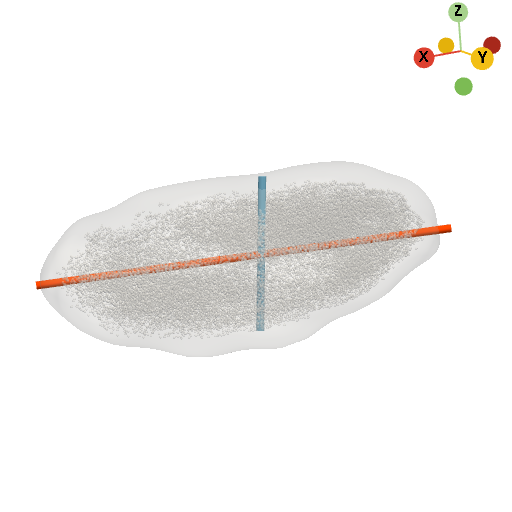

In [17]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([embryo_mesh, embryo_pc, ap_line, dv_line]),
    model_style=["surface", "points", "wireframe", "wireframe"],
    colormap=["gainsboro", "gainsboro", "orangered", "skyblue"],
    model_size=[3, 3, 8, 8],
    opacity=[0.2, 0.3, 1, 1],
    cpo=cpo,
    jupyter="static",
    show_legend=False,
    window_size=(512, 512),
)

## Differential genes expression tests along AP/DV axis using generalized linear regressions

In [18]:
axis="dv_axis"
glm_key = f"glm_degs_{axis}"
st.tl.glm_degs(adata=embryo_adata, fullModelFormulaStr=f"~cr({axis}, df=3)", key_added=glm_key, qval_threshold=0.01, llf_threshold=-2500)
embryo_glm_data = embryo_adata.uns[glm_key]["glm_result"]
embryo_glm_data

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [2202.5779s]


,status,family,log-likelihood,pval,qval
mt:lrRNA,ok,NB2,-68868.195312,0.000000,0.000000
mt:ND5,ok,NB2,-24257.716797,0.000000,0.000000
mt:srRNA,ok,NB2,-23115.775391,0.000000,0.000000
Nplp2,ok,NB2,-23097.445312,0.000000,0.000000
lncRNA:CR30009,ok,NB2,-22438.078125,0.000000,0.000000
...,...,...,...,...,...
LBR,ok,NB2,-7330.010254,0.003961,0.009829
CG14478,ok,NB2,-10290.786133,0.003970,0.009844
CG13220,ok,NB2,-7559.080078,0.003995,0.009900
RpL34a,ok,NB2,-28962.595703,0.004013,0.009940


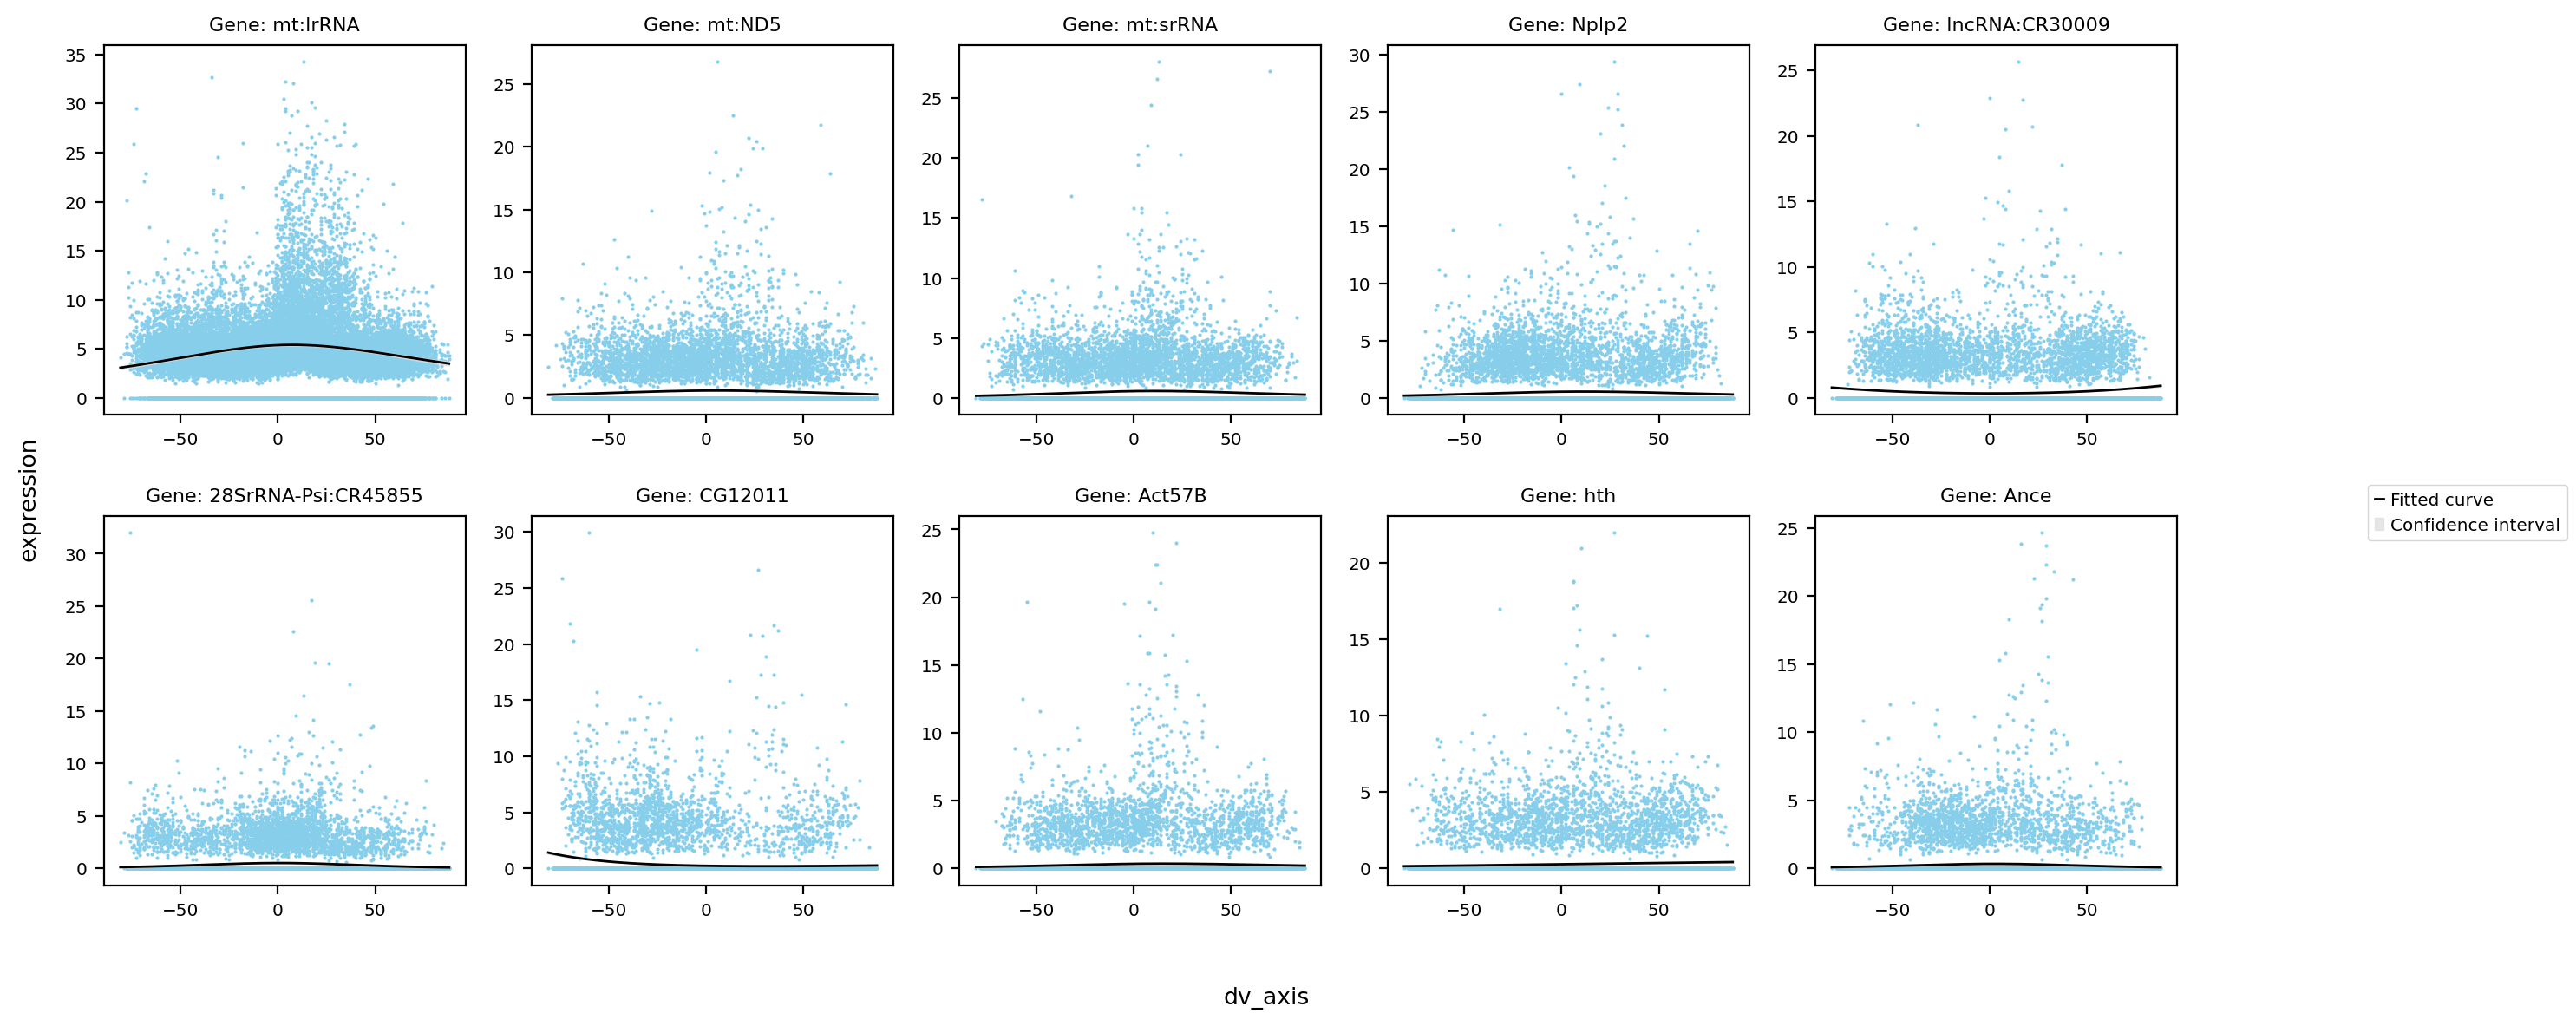

In [19]:
st.pl.glm_fit(
    adata=embryo_adata,
    gene=embryo_glm_data.index.tolist()[:10],
    ncols=5,
    feature_x=axis,
    feature_y="expression",
    feature_fit="mu",
    glm_key=glm_key,
    save_show_or_return="show",
)

### GO enrichment based on enrichr

In [20]:
gp.get_library_name(organism="fly")

['Allele_LoF_Phenotypes_from_FlyBase_2017',
 'Allele_Phenotypes_from_FlyBase_2017',
 'Anatomy_AutoRIF',
 'Anatomy_AutoRIF_Predicted_zscore',
 'Anatomy_GeneRIF',
 'Anatomy_GeneRIF_Predicted_zscore',
 'Coexpression_Predicted_GO_Biological_Process_2018',
 'Coexpression_Predicted_GO_Cellular_Component_2018',
 'Coexpression_Predicted_GO_Molecular_Function_2018',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_GeneRIF',
 'GO_Biological_Process_GeneRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_GeneRIF',
 'GO_Cellular_Component_GeneRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF',
 'GO_Molecular_Function_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_GeneRIF',
 'GO_Molecular_Function_GeneRIF_Predicted_zscore',
 'Human_Disease_from_FlyBase_2017',
 

In [13]:
embryo_glm_go = gp.enrichr(
    gene_list=embryo_glm_data.index.tolist(),
    gene_sets="GO_Biological_Process_2018",
    organism="fly",
    outdir="go_bp_result",
    no_plot=True,
    verbose=True
)
embryo_glm_go_results = embryo_glm_go.results
embryo_glm_go_results.head(10)

2022-10-14 01:40:26,460 Connecting to Enrichr Server to get latest library names
2022-10-14 01:40:27,968 Analysis name: , Enrichr Library: GO_Biological_Process_2018
2022-10-14 01:40:41,966 Save file of enrichment results: Job Id:d458d70c1d419fc377755eeda25e566f
2022-10-14 01:40:41,980 Done.



,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,GO_Biological_Process_2018,"regulation of transcription, DNA-templated (GO...",161/623,0.000000e+00,0.000000e+00,9.892965e-08,0.000055,-1.047207,88.525079,jigr1;fs(1)h;lmd;REPTOR-BP;pum;lola;peb;skd;Ol...
1,GO_Biological_Process_2018,negative regulation of cellular macromolecule ...,67/179,0.000000e+00,0.000000e+00,2.596111e-08,0.000021,-1.416952,82.517928,fs(1)h;bru3;msi;bru2;Kr;Fmr1;pum;Optix;Rbfox1;...
2,GO_Biological_Process_2018,regulation of transcription from RNA polymeras...,154/630,0.000000e+00,0.000000e+00,3.217498e-06,0.000560,-1.040632,76.870319,jigr1;lmd;Tet;Axud1;lola;peb;skd;asf1;gcm;exd;...
3,GO_Biological_Process_2018,negative regulation of gene expression (GO:001...,88/245,0.000000e+00,0.000000e+00,8.512170e-10,0.000002,-1.053588,76.396113,fs(1)h;bru3;msi;bru2;Ge-1;Kr;Fmr1;pum;put;Opti...
4,GO_Biological_Process_2018,"positive regulation of transcription, DNA-temp...",109/379,0.000000e+00,0.000000e+00,2.056014e-07,0.000092,-1.006687,67.492905,lmd;Tet;REPTOR-BP;Axud1;lola;Rbfox1;gcm;exd;mo...
5,GO_Biological_Process_2018,axon guidance (GO:0007411),82/242,0.000000e+00,0.000000e+00,2.779852e-08,0.000021,-1.056971,66.548159,Nrg;Kr;Fmr1;egh;ago;lola;peb;Oli;put;Ptp69D;gc...
6,GO_Biological_Process_2018,negative regulation of nucleic acid-templated ...,51/132,0.000000e+00,0.000000e+00,5.656474e-07,0.000141,-1.398374,64.769205,fs(1)h;Kr;pum;Optix;Dsp1;lolal;E(z);MBD-like;p...
7,GO_Biological_Process_2018,nervous system development (GO:0007399),79/246,0.000000e+00,0.000000e+00,3.110317e-07,0.000103,-1.088587,61.710948,Fmr1;Rbfox1;exd;barr;Nrt;Adf1;E(z);pim;Myc;Doa...
8,GO_Biological_Process_2018,eye morphogenesis (GO:0048592),38/114,1.765000e-13,9.207400e-12,1.981325e-04,0.009456,-2.018161,59.264058,hyx;bi;dome;put;Optix;Hrb98DE;sd;ave;p120ctn;t...
9,GO_Biological_Process_2018,cytoskeleton-dependent cytokinesis (GO:0061640),31/69,2.100000e-15,1.540000e-13,9.151327e-06,0.000892,-1.745305,58.958696,Act42A;scra;sqh;Drp1;chic;feo;tsr;Sep1;pim;Zw1...


In [14]:
gp.barplot(embryo_glm_go_results, column='Combined Score', title='GO_Biological_Process_2018', cutoff=0.05, top_term=100,
           figsize=(10, 25), ofname=f"go_bp_barplot.pdf")

In [15]:
gp.dotplot(embryo_glm_go_results, column='Combined Score', title='GO_Biological_Process_2018', cmap='viridis_r', cutoff=0.05, top_term=100,
           figsize=(10, 25), ofname=f"go_bp_dotplot.pdf")